In [26]:
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
from EconModel  import EconModelClass
from types import SimpleNamespace
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # without this python may crash when plotting from matplotlib
import matplotlib.pyplot as plt

In [27]:
torch.manual_seed(0)

## Buffer-stock model

$$
v_t(m_t,p_t) = \max_{a_t} u(c_t)+\beta E_t[v_{t+1}(m_{t+1},p_{t+1})] \\
\text{s.t.} \\
c_t = (1-a_t)m_t \\
m_{t+1} = (1+r)(m_t-c_t) + \text{income}_{t+1} \\
\text{income}_{t+1} = \kappa_{t+1} \psi_{t+1}p_{t+1} \\
p_{t+1} = \xi_{t+1}p_t^{\rho} \\
a_t \in [0,1]
$$

$a_t$ = $\pi(s_t)$ is approximated with neural network $\pi(s_t) \approx \pi^{DNN}(t,s_t;\theta_\pi)$

### 1. Creating a neural network class in python - Almost model-independent

In [28]:
class Policy(nn.Module):
    """ Policy function """
    
    def __init__(self,par,train):

        super(Policy,self).__init__()

        self.Nstates = par.Nstates # number of states
        self.T = par.T # number of time periods
        self.Nactions = par.Nactions # number of actions

        self.layers = nn.ModuleList([None]*(train.Nneurons_policy.size+1)) # create list of layers
    
        # input layer
        self.layers[0] = nn.Linear(self.Nstates+self.T, train.Nneurons_policy[0]) # shape: (Nstates+T, Nneurons_policy[0])

        # hidden layers
        for i in range(1,len(self.layers)-1):
            self.layers[i] = nn.Linear(train.Nneurons_policy[i-1],train.Nneurons_policy[i])  # shape: (Nneurons_policy[i-1], Nneurons_policy[i])
        
        # output layer
        self.layers[-1] = nn.Linear(train.Nneurons_policy[-1],self.Nactions) # shape: (Nneurons_policy[-1], Nactions)
        
    def forward(self, state):
        """ Forward pass of neural network: This means giving the state to the network and retrieving the action """
        
        # Input layer
        s = F.relu(self.layers[0](state))  # Use ReLU activation for input layer
        
        # Hidden layers
        for layer in self.layers[1:-1]:
            s = F.relu(layer(s))    # Use ReLU activation for hidden layers
        
        # Output layer with fixed sigmoid activation
        action = torch.sigmoid(self.layers[-1](s))
        
        return action


def eval_policy(model,NN,x,t):
    """ 
    Evaluate neural network with time-dummies

    NN: neural network object
    NNT: neural network  number of time-dummies
    x: input data without time-dummies
    t: period index
    
    """

    par = model.par

    # create time-dummies
    Nx = x.shape[0] # number of agents
    time_dummmies = torch.zeros((Nx,par.T),dtype=model.dtype,device=x.device) # create vecto
    time_dummmies[:,t] = 1.0 # set time-dummy to 1.0 at period t

    # concatenate time-dummies to input data
    x = torch.cat((x,time_dummmies),dim=-1)

    # evaluate neural network
    action = NN(x)

    return action




### 2. Create code to create optimizer and update step

In [29]:

def create_opt(model):
    """ Create optimizer for policy """

    # a. unpack
    train = model.train
    
    # b. create optimizer
    model.policy_opt = torch.optim.Adam(
        model.policy_NN.parameters(),
        lr=train.learning_rate_policy)

In [30]:
def policy_update_step(model,loss):
	""" update policy parameters given loss """

	# a. unpack
	policy_opt = model.policy_opt
	
	# b. update parameters
	policy_opt.zero_grad()
	loss.backward()
	policy_opt.step()

	return loss.item()

### 3. Writing loss-function for simulation approach


In [31]:
def simulate_loss(model,policy_NN,initial_states,shocks):
	""" Simulate to get objective function for policy optimization"""

	# a. unpack
	par = model.par
	train = model.train
	dtype = model.dtype
	device = model.device

	# b. allocate
	N = initial_states.shape[0]
	discount_factor = torch.zeros((par.T,N),dtype=dtype,device=device)	
	reward = torch.zeros((par.T,N),dtype=dtype,device=device)
	new_states_t = torch.zeros((N,par.Nstates),dtype=dtype,device=device)
	
	# c. simulate
	for t in range(par.T):

		# i. states in period t 
		if t > 0:
			states_t = new_states_t.clone()
		else:
			states_t = initial_states
		
		# ii. endogenous actions
		actions_t = model.eval_policy(policy_NN,states_t,t=t)

		# iii. reward and discount factor
		outcomes_t = model.outcomes(states_t,actions_t,t=t)
		reward[t] = model.reward(states_t,actions_t,outcomes_t,t=t)
		discount_factor[t] = par.beta**t

		# iv. transition
		if t < par.T-1:
			new_states_t[:,:] = model.state_trans(states_t,actions_t,outcomes_t,shocks[t+1],t=t)
			
	# d. compute discounted utility
	R = torch.sum(discount_factor*reward)/train.N
	loss = -R # - because we minimize negative reward

	return loss

### 4. Write simulation algorithm


In [32]:
def train_policy(model, K=100):
    """ train policy function with simulation approach """

    """ 
    K: number of iterations to train policy
    """
    train = model.train
    
    # training loop
    for k in range(K):

        # i. draw initial states and shocks
        initial_states = model.draw_initial_states(N=train.N)
        shocks = model.draw_shocks(N=train.N)
        
        # ii. simulate loss
        loss = simulate_loss(model,model.policy_NN,initial_states,shocks)

        # iii. update policy parameters
        policy_update_step(model,loss)

        # iv. print progress
        if k % 10 == 0:
            print(f"Iteration {k}: Loss {loss.item()}")

### 5. Create model class

In [33]:
class Model:  # Inherit from DLSolverClass if needed
    def __init__(self):
        self.par = SimpleNamespace() # for storing model stuff
        self.train = SimpleNamespace() # for storing training stuff
        self.sim = SimpleNamespace() # for storing simulation stuff

        self.dtype = torch.float32
        self.device = 'cpu'

        self.setup() # Setup model parameters
        self.allocate() # Allocate model objects
        self.setup_train()  # Setup training parameters
        self.allocate_train() # Allocate training objects
    
    create_opt = create_opt # insert function to create optimizer
    eval_policy = eval_policy # insert function to evaluate policy

    
    # setup empty functions to be overwritten

    # Setup and allocate
    def setup(self): pass
    def allocate(self): pass
    def setup_train(self): pass
    def allocate_train(self): pass

    # Draw
    def draw_initial_states(self): pass
    def draw_shocks(self): pass

    # Transition
    def state_trans(self): pass  # Post-decision states, shocks -> next-period states

    # Reward
    def reward(self): pass  # Utility

### 6. Create setup and allocate functions for Bufferstock model

In [34]:
def setup(self,full=None):
    """ choose parameters """

    par = self.par
    sim = self.sim
    
    # a. model
    par.T = 10 # number of periods

    # preferences
    par.beta = 1/1.01 # discount factor

    # income
    par.kappa_base = 1.0
    par.rho_p= 0.95 # shock, persistenc
    par.sigma_xi = 0.1 # shock, permanent
    par.sigma_psi = 0.1 # shock, transitory std

    # return
    par.R = 1.01 # gross return

    # b. solver settings
    par.Nstates = 2 # number of states variables
    par.Nactions = 1 # number of actions variables
    par.Nshocks = 2 # number of shocks

    # c. simulation 
    sim.N = 50_000 # number of agents

    # initial states
    par.mu_m0 = 1.0 # initial cash-on-hand, mean
    par.sigma_m0 = 0.1 # initial cash-on-hand, std

    # initial permanent income
    par.mu_p0 = 1.0 # initial durable, mean
    par.sigma_p0 = 0.1 # initial durable, std


    sim.N = 10_000 # number of simulated agents

Model.setup = setup


In [35]:
def allocate(model):
    """ allocate arrays  """

    # unpack
    par = model.par
    sim = model.sim

    # b. simulation (same across models)
    sim.states = torch.zeros((par.T,sim.N,par.Nstates)) # State-vector
    sim.shocks = torch.zeros((par.T,sim.N,par.Nshocks)) # Shock-vector
    sim.actions = torch.zeros((par.T,sim.N,par.Nactions))  # actions array
    sim.reward = torch.zeros((par.T,sim.N)) # array for utility rewards
    sim.outcomes = torch.zeros((par.T,sim.N,1)) # array for outcomes - will just be consumption
    sim.R = np.nan # initialize average discounted utility

Model.allocate = allocate


In [ ]:
def setup_train(model):
    """ default parameters for training """
    
    train = model.train

    # a. neural network
    train.Nneurons_policy = np.array([100,100]) # number of neurons in hidden layers

    train.N = 3000 # number of agents for training

    train.learning_rate_policy = 1e-3 # learning rate for policy

Model.setup_train = setup_train

In [37]:
def allocate_train(model):
    """ allocate memory training """

    par = model.par
    train = model.train
    device = model.device

    # a. neural network
    model.policy_NN = Policy(par,train).to(device) # policy neural network
    model.create_opt() # create optimizer for policy neural network

Model.allocate_train = allocate_train

### 7. create functions for random draws

In [38]:
def draw_initial_states(model,N):
    """ draw initial state (m,p,t) """

    par = model.par
    train = model.train

    sigma_m0 = par.sigma_m0
    sigma_p0 = par.sigma_p0

    # a. draw cash-on-hand:	
    m0 = par.mu_m0*np.exp(torch.normal(-0.5*sigma_m0**2,sigma_m0,size=(N,)))
    
    # b. draw permanent income
    p0 = par.mu_p0*np.exp(torch.normal(-0.5*sigma_p0**2,sigma_p0,size=(N,)))

    # c. store
    return torch.stack((m0,p0),dim=1)

Model.draw_initial_states = draw_initial_states

In [39]:
def draw_shocks(model,N):
    """ draw shocks """

    par = model.par

    # xi 
    xi_loc = -0.5*par.sigma_xi**2
    xi = np.exp(torch.normal(xi_loc,par.sigma_xi,size=(par.T,N,)))

    # psi
    psi_loc = -0.5*par.sigma_psi**2
    psi = np.exp(torch.normal(psi_loc,par.sigma_psi,size=(par.T,N,)))

    return torch.stack((xi,psi),dim=-1)

Model.draw_shocks = draw_shocks

### 8. Outcome and state transitions functions

In [40]:
def outcomes(model,states,actions,t=None):
	""" outcomes - just consumption here """

	m = states[...,0] # cash-on-hand
	a = actions[...,0] # savings rate
	c = m*(1-a) # consumption

	return torch.stack((c,),dim=-1) # (T,N,Noutcomes)

Model.outcomes = outcomes

In [41]:
def state_trans(model,states,actions,outcomes,shocks,t=None):
	""" transition to future state """


	# a. unpack
	par = model.par
	xi = shocks[...,0] # permanent income shock
	psi = shocks[...,1] # transitory income shock
	m = states[...,0]
	p = states[...,1]
	c = outcomes[...,0]

	# c. post-decision
	m_pd = m-c
	
    # d. persistent income
	p_plus = p**par.rho_p * xi # permanent income
	
    # d. income
	income = par.kappa_base * p_plus * psi # income
	
    # e. future cash-on-hand
	m_plus = par.R * m_pd + income # future cash-on-hand

	# d. finalize
	states_pd = torch.stack((m_plus,p_plus),dim=-1)
	return states_pd


Model.state_trans = state_trans

### 9. reward function

In [42]:
def utility(par,c):
	""" utility """

	return torch.log(c)

def reward(model,states,actions,outcomes,t0=0,t=None):
	""" reward """

	# a. unpack
	par = model.par

	# b. consumption
	c = outcomes[...,0]

	# c. utility
	u = utility(par,c)

	return u 

Model.reward = reward


### 10. Simulation for storing

In [43]:
def simulate(model):
	""" Simulate to get loss in DeepSimulate """

	# a. unpack
	torch.manual_seed(0) # for reproducibility
	par = model.par
	sim = model.sim
	dtype = model.dtype
	device = model.device
	
	states = sim.states
	actions = sim.actions
	rewards = sim.reward
	outcomes = sim.outcomes

	# b. draw initial states
	with torch.no_grad():
		states[0] = model.draw_initial_states(N=sim.N)
		shocks = model.draw_shocks(N=sim.N)
		
		# c. simulate
		for t in range(par.T):


			#i. compute actions
			actions[t] = model.eval_policy(model.policy_NN,states[t],t=t)

			# ii. compute outcomes
			outcomes[t] = model.outcomes(states[t],actions[t],t=t)

			# iii. compute rewards
			rewards[t] = model.reward(states[t],actions[t],outcomes[t],t=t)

			# iv. transition
			if t < par.T-1:
				states[t+1] = model.state_trans(states[t],actions[t],outcomes[t],shocks[t+1],t=t)
				

		# d. compute discounted utility
		discount_factor = torch.zeros((par.T,sim.N),dtype=dtype,device=device)
		for t in range(par.T):
			discount_factor[t] = par.beta**t
		R = torch.sum(discount_factor*rewards)/sim.N

	return R
Model.simulate = simulate

In [44]:
model = Model() # create model object

In [45]:
train_policy(model, K=2000) # train policy

Iteration 0: Loss 1.355010747909546
Iteration 10: Loss 0.8219365477561951
Iteration 20: Loss 0.5039828419685364
Iteration 30: Loss 0.37304529547691345
Iteration 40: Loss 0.3056012690067291
Iteration 50: Loss 0.26125243306159973
Iteration 60: Loss 0.26256781816482544
Iteration 70: Loss 0.27449625730514526
Iteration 80: Loss 0.2524772882461548
Iteration 90: Loss 0.27796265482902527
Iteration 100: Loss 0.27075138688087463
Iteration 110: Loss 0.2655380368232727
Iteration 120: Loss 0.28128543496131897
Iteration 130: Loss 0.2787419855594635
Iteration 140: Loss 0.24329304695129395
Iteration 150: Loss 0.3028475046157837
Iteration 160: Loss 0.28507429361343384
Iteration 170: Loss 0.2851763367652893
Iteration 180: Loss 0.2713242173194885
Iteration 190: Loss 0.23478154838085175
Iteration 200: Loss 0.25111478567123413
Iteration 210: Loss 0.22983966767787933
Iteration 220: Loss 0.2835014760494232
Iteration 230: Loss 0.25796496868133545
Iteration 240: Loss 0.29282984137535095
Iteration 250: Loss 0.3

In [51]:
model.simulate() # simulate model

tensor(-0.2300)

Text(0, 0.5, 'Consumption')

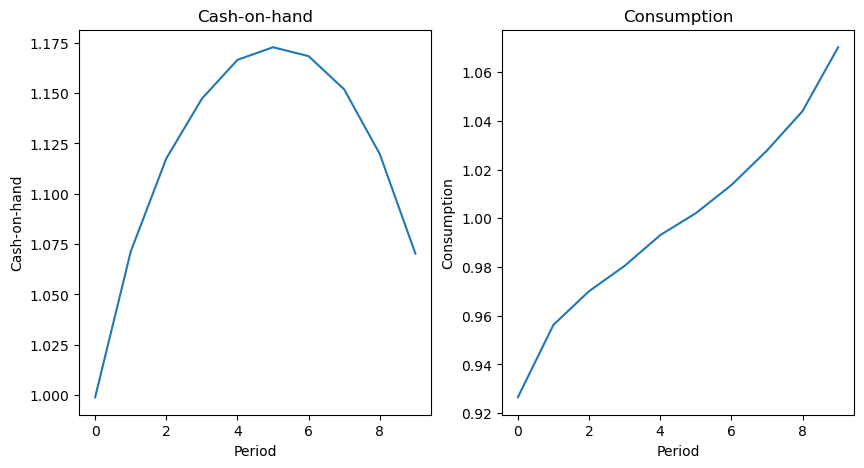

In [52]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(torch.mean(model.sim.states[:, :, 0], dim=1).cpu().numpy(), label='Cash-on-hand')
ax[0].set_title('Cash-on-hand')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Cash-on-hand')

ax[1].plot(torch.mean(model.sim.outcomes[:, :, 0], dim=1).cpu().numpy(), label='consumption')
ax[1].set_title('Consumption')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Consumption')

In [53]:
train_policy(model, K=300) # train policy

Iteration 0: Loss 0.24138163030147552
Iteration 10: Loss 0.25052759051322937
Iteration 20: Loss 0.2307615578174591
Iteration 30: Loss 0.2664768397808075
Iteration 40: Loss 0.25092536211013794
Iteration 50: Loss 0.18726147711277008
Iteration 60: Loss 0.2706843316555023
Iteration 70: Loss 0.24360601603984833
Iteration 80: Loss 0.22573205828666687
Iteration 90: Loss 0.22903352975845337
Iteration 100: Loss 0.2520230710506439
Iteration 110: Loss 0.20691730082035065
Iteration 120: Loss 0.21364614367485046
Iteration 130: Loss 0.2192394882440567
Iteration 140: Loss 0.25173938274383545
Iteration 150: Loss 0.2559496760368347
Iteration 160: Loss 0.2214086502790451
Iteration 170: Loss 0.1808948814868927
Iteration 180: Loss 0.2770715057849884
Iteration 190: Loss 0.2854548394680023
Iteration 200: Loss 0.26327207684516907
Iteration 210: Loss 0.27551349997520447
Iteration 220: Loss 0.24805407226085663
Iteration 230: Loss 0.18742747604846954
Iteration 240: Loss 0.21849766373634338
Iteration 250: Loss 0

In [49]:
model.simulate() # simulate model

tensor(-0.2300)

Text(0, 0.5, 'Consumption')

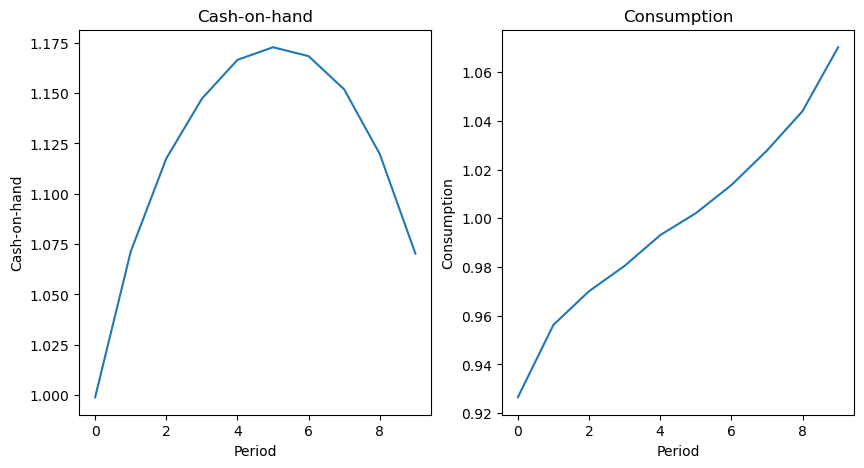

In [50]:
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(torch.mean(model.sim.states[:, :, 0], dim=1).cpu().numpy(), label='Cash-on-hand')
ax[0].set_title('Cash-on-hand')
ax[0].set_xlabel('Period')
ax[0].set_ylabel('Cash-on-hand')

ax[1].plot(torch.mean(model.sim.outcomes[:, :, 0], dim=1).cpu().numpy(), label='consumption')
ax[1].set_title('Consumption')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Consumption')